In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from shark.utils import nb_init
nb_init()

INFO | nb_init | Set current dir to chess
INFO | nb_init | You are using Python 3.10.10 (main, Sep 14 2023, 16:59:47) [Clang 14.0.3 (clang-1403.0.22.14.1)]


# CQL on Inverted Double Pendulum

In [7]:
from loguru import logger
import os
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
import pandas as pd

from shark.models import CQLPendulum
from shark.utils import plot_metrics

## Create model

We choose the gymnasium environment here.

In [8]:
frame_skip = 1
frames_per_batch = frame_skip * 100
model = CQLPendulum(
    frame_skip=frame_skip,
    frames_per_batch=frames_per_batch,
)

## Rollout

We can immediately try to play, and check what playing returns.

In [11]:
rollout = model.env.rollout(3)
logger.info(f"Rollout of three steps: {rollout}")
logger.info(f"Shape of the rollout TensorDict: {rollout.batch_size}")
logger.info(f"Running policy: {model.policy_module(model.env.reset())}")

INFO | <module> | Rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([1, 3, 11]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            ba

## Data

This is what a batch of data looks like.

In [12]:
# Collector
collector = model.train_dataloader()
for _, tensordict_data in enumerate(collector):
    logger.info(f"Tensordict data:\n{tensordict_data}")
    break

INFO | <module> | Tensordict data:
TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1, 100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([1, 100]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([1, 100]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([1, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([1, 100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([1, 100, 11]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([1, 100, 1]), device=cpu, dtype=torch.float32, is

In [13]:
# Training
trainer = pl.Trainer(
    accelerator="cpu",
    max_steps=8,
    val_check_interval=1,
    log_every_n_steps=1,
    logger=CSVLogger(
        save_dir="pytest_artifacts",
        name=model.__class__.__name__,
    ),
)
trainer.fit(model)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.
Missing logger folder: pytest_artifacts/CQLPendulum

  | Name          | Type               | Params
-----------------------------------------------------
0 | env           | SerialEnv          | 0     
1 | loss_module   | CQLLoss            | 675 K 
2 | policy_module | ProbabilisticActor | 135 K 
3 | value_module  | ValueOperator      | 135 K 
-----------------------------------------------------
540 K     Trainable params
270 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=8` reached.


In [14]:
# Get logged stuff
log_dir = trainer.log_dir
assert isinstance(log_dir, str)
logs = trainer.logged_metrics
assert isinstance(logs, dict)
logger.info(log_dir)
logger.info(logs)
filename = os.path.join(log_dir, "metrics.csv")
df = pd.read_csv(filename)
logger.info(df.head())

INFO | <module> | pytest_artifacts/CQLPendulum/version_0
INFO | <module> | {'loss_actor/train': tensor(-0.4950), 'loss_actor_bc/train': tensor(-0.4449), 'loss_qvalue/train': tensor(16.4768), 'loss_cql/train': tensor(2.6161), 'loss_alpha/train': tensor(-0.0033), 'loss/train': tensor(1985.9989), 'reward/train': tensor(8.9720), 'step_count/train': tensor(4.), 'reward/eval': tensor(9.0399), 'reward_sum/eval': tensor(36.1595), 'step_count/eval': tensor(3.)}
INFO | <module> |    epoch   loss/train  loss_actor/train  loss_actor_bc/train  \
0      0  1995.932251          0.111279            -0.980709   
1      0  1985.916748         -0.088734             0.080928   
2      0  1987.866821          0.877827             0.273090   
3      0  2016.548828          0.656822             0.852420   
4      0  1993.942749          0.585476            -1.636265   

   loss_alpha/train  loss_cql/train  loss_qvalue/train  reward/eval  \
0          0.000000        2.677219          16.920534     8.996449  

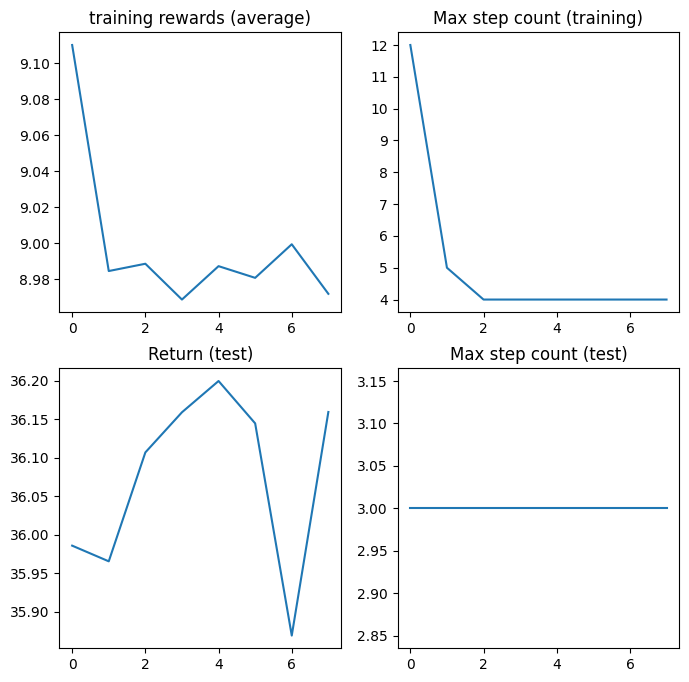

In [15]:
import matplotlib.pyplot as plt

# Plot
plot_metrics(df, show=True)